In [1]:
import numpy as np
import pandas as pd
import string as st
import random
import sklearn.cluster as skc
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import pairwise_distances

In [2]:
spam = pd.read_csv("spambase.data", header = None).values

### K-Means

#### pairwise

In [3]:
def Kmeans(data, k, max_iter = 1000):
    
    """This function implements the K-Means Algorith"""
    
    if type(data) == pd.DataFrame: data = data.values
    
    nrow = data.shape[0]
    index = np.random.choice(range(nrow), k, False)
    centers = data[index]
    cost = []
    iter = 1
    
    while (iter <= max_iter):
        ## calculate distance & labels
        distance = pairwise_distances(data, centers)**2
        cost.append(sum(np.min(distance, axis=1)))
        labels = np.argmin(distance, axis=1)
        
        ## update centers
        centers_new = np.array([np.mean(data[labels == i], axis=0) for i in np.unique(labels)])
        
        ## sanity check
        if(np.all(centers == centers_new)): break 
        centers = centers_new
        iter += 1
    
    if (sum(np.min(pairwise_distances(data, centers)**2, axis=1)) != cost[-1]):
        warnings.warn("Algorithm Did Not Converge In {} Iterations".format(max_iter))
        
    return labels, cost, iter, centers

#### manuscript

In [4]:
def Kmeans_manu(data, k, max_iter = 1000):
    
    """This function implements the K-Means Algorith"""
    
    if type(data) == pd.DataFrame: data = data.values
    
    nrow = data.shape[0]
    index = np.random.choice(range(nrow), k, False)
    centers = data[index]
    cost = []
    iter = 1
    
    while (iter <= max_iter):
        distance = np.zeros([nrow, len(centers)])
        ## calculate distance & labels
        for i in range(nrow):
            for j in range(len(centers)):
                distance[i,j] = np.linalg.norm(data[i] - centers[j])**2        
        cost.append(sum(np.min(distance, axis=1)))
        labels = np.argmin(distance, axis=1)
        
        ## update centers
        centers_new = np.array([np.mean(data[labels == i], axis=0) for i in np.unique(labels)])
        
        ## sanity check
        if(np.all(centers == centers_new)): break 
        centers = centers_new
        iter += 1
    
    return labels, cost, iter, centers

In [5]:
random.seed(816)
%timeit Kmeans(spam, 5)
%timeit Kmeans_manu(spam, 5)

110 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.38 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### K-Means++

In [6]:
def calc_distances(data, centers, weights):
    
    """This function returns distance matrix"""
    
    distance = pairwise_distances(data, centers)**2
    min_distance = np.min(distance, axis = 1)
    D = min_distance*weights
    return D

In [7]:
def initial_centers_Kmeansapp(data, k, weights):
    
    """retrun k initial centers from the original data points"""
    
    centers = []
    centers.append(random.choice(data))
    
    while(len(centers) < k):   
        ## calculate distance
        distances = calc_distances(data, centers, weights)
    
        ## update centers
        prob = distances/sum(distances)
        c = np.random.choice(range(data.shape[0]), 1, p=prob)
        centers.append(data[c[0]])

    return centers

In [8]:
def Kmeans_pp(data, k, weights=None, max_iter = 100000):
    
    """This function implements the K-Means++ Algorith"""
    
    ## choose weights
    if weights is None: weights = np.ones(len(data))
    if type(data) == pd.DataFrame: data=data.values
    
    ## initialize centers
    nrow = data.shape[0]
    centers = initial_centers_Kmeansapp(data,k,weights)
    cost = []
    iter = 1
    
    while (iter <= max_iter):
        
        ## calculate distance & labels
        distance = pairwise_distances(data, centers)**2
        labels = np.argmin(distance, axis=1)
        cost.append(sum(np.min(distance, axis=1)))
        
        ## update centers
        centers_new = np.array([np.mean(data[labels == i], axis=0) for i in np.unique(labels)])
        
        ## sanity check
        if(np.all(centers == centers_new)): break 
        centers = centers_new
        iter += 1
    
    if (sum(np.min(pairwise_distances(data, centers)**2, axis=1)) != cost[-1]):
        warnings.warn("Algorithm Did Not Converge In {} Iterations".format(max_iter))

    return labels, cost, iter, centers

### K-Meansll

In [9]:
def calc_weight(data, centers):
    
    """This function returns the weights"""
    
    ## calculate distancs
    l = len(centers)
    distance = pairwise_distances(data, centers)
    labels = np.argmin(distance, axis=1)
    
    ## calculate weights    
    weights = [sum(labels == i) for i in range(l)]
    
    return (weights/sum(weights))

In [10]:
def initial_centers_Kmeansll(data, k, omega, weights):
    """This function returns the initial center for K-Meansll"""
    
    centers = []
    centers.append(random.choice(data))
    phi = np.int(np.round(np.log(sum(calc_distances(data, centers, weights)))))
    l = k*omega ## oversampling factor
    
    for i in range(phi):
        dist = calc_distances(data, centers, weights)
        prob = l*dist/sum(dist)
        for i in range(len(prob)):
            if prob[i] > np.random.uniform():
                centers.append(data[i])
    
    centers = np.array(centers)
    recluster_weight = calc_weight(data, centers)
    reclusters = Kmeans_pp(centers, k, recluster_weight)[0]

    initial_centers = []
    for i in np.unique(reclusters):
        initial_centers.append(np.mean(centers[reclusters == i], axis = 0))
    
    return initial_centers

In [11]:
def Kmeansll(data, k, omega, weights=None, max_iter = 10000):
    
    """This function implements the K-Means++ Algorith"""
    
    if weights is None: weights = np.ones(len(data))
    if type(data) == pd.DataFrame: data=data.values
    
    ## initialize centers
    nrow = data.shape[0]
    centers = initial_centers_Kmeansll(data, k, omega, weights)
    cost = []
    iter = 1
    
    while (iter <= max_iter):
        
        ## calculate distance & labels
        distance = pairwise_distances(data, centers)**2
        labels = np.argmin(distance, axis=1)
        cost.append(sum(np.min(distance, axis=1)))
        
        ## update centers
        centers_new = np.array([np.mean(data[labels == i], axis=0) for i in np.unique(labels)])
        
        ## sanity check
        if(np.all(centers == centers_new)): break 
        centers = centers_new
        iter += 1
    
    if (sum(np.min(pairwise_distances(data, centers)**2, axis=1)) != cost[-1]):
        warnings.warn("Algorithm Did Not Converge In {} Iterations".format(max_iter))

    return labels, cost, iter, centers

## Simulated Data

In [12]:
cluster1 = np.c_[np.random.normal(1, 0.5, 1000), np.random.normal(2, 0.5, 1000)]
cluster2 = np.c_[np.random.normal(6, 0.5, 1000), np.random.normal(3, 0.5, 1000)]
cluster3 = np.c_[np.random.normal(3, 0.5, 1000), np.random.normal(5, 0.5, 1000)]
cluster4 = np.c_[np.random.normal(4, 0.5, 1000), np.random.normal(0, 0.5, 1000)]
cluster5 = np.c_[np.random.normal(3.5, 0.5, 500), np.random.normal(2, 0.5, 500)]
simulation = np.r_[cluster1, cluster2, cluster3, cluster4, cluster5]

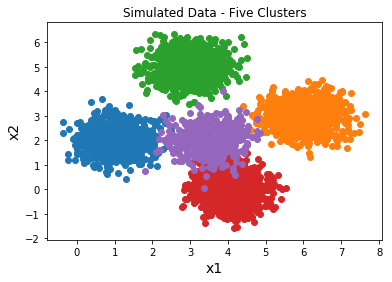

In [13]:
plt.scatter(cluster1[:,0], cluster1[:,1])
plt.scatter(cluster2[:,0], cluster2[:,1])
plt.scatter(cluster3[:,0], cluster3[:,1])
plt.scatter(cluster4[:,0], cluster4[:,1])
plt.scatter(cluster5[:,0], cluster5[:,1])
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("Simulated Data - Five Clusters")
pass

#### K-Means

In [14]:
label1, cost1, iter1, centers1 = Kmeans(simulation, 5)

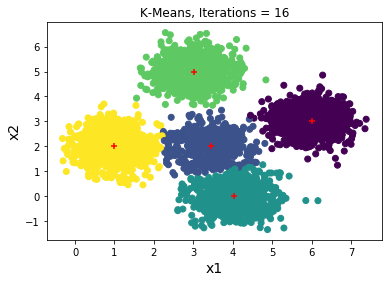

In [141]:
plt.scatter(simulation[:,0], simulation[:,1], c=label1)
plt.scatter(centers1[0][0], centers1[0][1], c="red", marker="+")
plt.scatter(centers1[1][0], centers1[1][1], c="red", marker="+")
plt.scatter(centers1[2][0], centers1[2][1], c="red", marker="+")
plt.scatter(centers1[3][0], centers1[3][1], c="red", marker="+")
plt.scatter(centers1[4][0], centers1[4][1], c="red", marker="+")
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("K-Means, Iterations = {}".format(iter1))
pass

#### K-Means ++

In [15]:
labels2, cost2, iter2, centers2 = Kmeans_pp(simulation, 5)

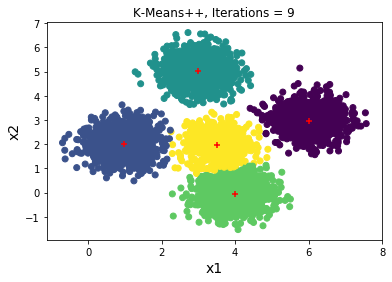

In [166]:
plt.scatter(simulation[:,0], simulation[:,1], c=labels2)
plt.scatter(centers2[0][0], centers2[0][1], c="red", marker="+")
plt.scatter(centers2[1][0], centers2[1][1], c="red", marker="+")
plt.scatter(centers2[2][0], centers2[2][1], c="red", marker="+")
plt.scatter(centers2[3][0], centers2[3][1], c="red", marker="+")
plt.scatter(centers2[4][0], centers2[4][1], c="red", marker="+")
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("K-Means++, Iterations = {}".format(iter2))
pass

#### K-Means ll

In [16]:
labels3, cost3, iter3, centers3 = Kmeansll(simulation, 5, 0.5)

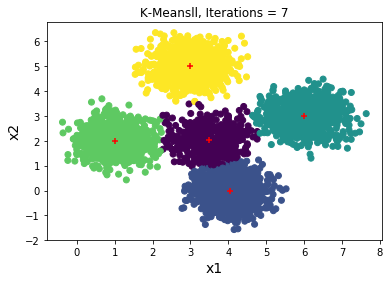

In [19]:
plt.scatter(simulation[:,0], simulation[:,1], c=labels3)
plt.scatter(centers3[0][0], centers3[0][1], c="red", marker="+")
plt.scatter(centers3[1][0], centers3[1][1], c="red", marker="+")
plt.scatter(centers3[2][0], centers3[2][1], c="red", marker="+")
plt.scatter(centers3[3][0], centers3[3][1], c="red", marker="+")
plt.scatter(centers3[4][0], centers3[4][1], c="red", marker="+")
plt.xlabel("x1", fontsize = 14)
plt.ylabel("x2", fontsize = 14)
plt.title("K-Meansll, Iterations = {}".format(iter3))
pass

In [17]:
labels4, cost4, iter4, centers4 = Kmeansll(simulation, 5, 1)

In [18]:
labels5, cost5, iter5, centers5 = Kmeansll(simulation, 5, 2)

In [21]:
%timeit Kmeans(simulation, 5)
%timeit Kmeans_pp(simulation, 5)
%timeit Kmeansll(simulation, 5, 0.5)
%timeit Kmeansll(simulation, 5, 1)
%timeit Kmeansll(simulation, 5, 2)

18.9 ms ± 951 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.8 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
359 ms ± 95.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
659 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.09 s ± 99.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


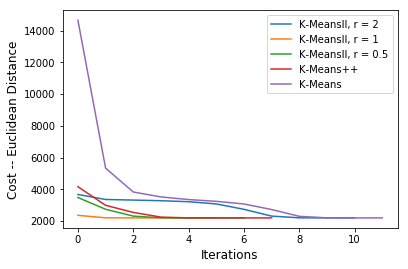

In [20]:
plt.plot(cost5)
plt.plot(cost4)
plt.plot(cost3)
plt.plot(cost2)
plt.plot(cost1)
plt.legend(("K-Meansll, r = 2","K-Meansll, r = 1","K-Meansll, r = 0.5", "K-Means++", "K-Means"))
plt.xlabel("Iterations", fontsize = 12)
plt.ylabel("Cost -- Euclidean Distance", fontsize = 12)
pass

## Real Data
### Spam Data
https://archive.ics.uci.edu/ml/datasets/Spambase

In [22]:
spam = pd.read_csv("spambase.data", header = None).values

#### K-Means

In [23]:
label1, cost1, iter1, center1 = Kmeans(spam, 20)

#### K-Means++

In [24]:
label2, cost2, iter2, centers2 = Kmeans_pp(spam, k=20)

#### K-Meansll

In [25]:
label3, cost3, iter3, center3 = Kmeansll(spam, k=20, omega=0.5)

In [26]:
label4, cost4, iter4, center4 = Kmeansll(spam, k=20, omega=1)

In [27]:
label5, cost5, iter5, center5 = Kmeansll(spam, k=20, omega=2)

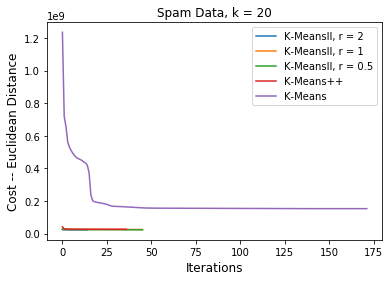

In [28]:
plt.plot(cost5)
plt.plot(cost4)
plt.plot(cost3)
plt.plot(cost2)
plt.plot(cost1)
plt.legend(("K-Meansll, r = 2","K-Meansll, r = 1","K-Meansll, r = 0.5", "K-Means++", "K-Means"))
plt.xlabel("Iterations", fontsize = 12)
plt.ylabel("Cost -- Euclidean Distance", fontsize = 12)
plt.title("Spam Data, k = 20")
pass

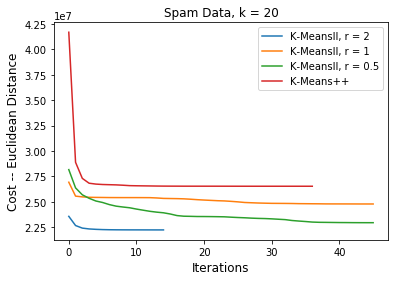

In [29]:
plt.plot(cost5)
plt.plot(cost4)
plt.plot(cost3)
plt.plot(cost2)
plt.legend(("K-Meansll, r = 2","K-Meansll, r = 1","K-Meansll, r = 0.5", "K-Means++"))
plt.xlabel("Iterations", fontsize = 12)
plt.ylabel("Cost -- Euclidean Distance", fontsize = 12)
plt.title("Spam Data, k = 20")
pass

In [30]:
%timeit Kmeans(spam, 20)
%timeit Kmeans_pp(spam, 20)
%timeit Kmeansll(spam, k=20, omega=0.5)
%timeit Kmeansll(spam, k=20, omega=1)
%timeit Kmeansll(spam, k=20, omega=2)

C:\Users\binha\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


831 ms ± 118 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
219 ms ± 48.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.27 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.93 s ± 290 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.56 s ± 646 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit Kmeans(spam, 50)
%timeit Kmeans_pp(spam, 50)
%timeit Kmeansll(spam, k=50, omega=0.5)
%timeit Kmeansll(spam, k=50, omega=1)
%timeit Kmeansll(spam, k=50, omega=2)

C:\Users\binha\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1.39 s ± 495 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
638 ms ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.52 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.81 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.2 s ± 910 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit Kmeans(spam, 100)
%timeit Kmeans_pp(spam, 100)
%timeit Kmeansll(spam, k=100, omega=0.5)
%timeit Kmeansll(spam, k=100, omega=1)
%timeit Kmeansll(spam, k=100, omega=2)

C:\Users\binha\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


592 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
937 ms ± 96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.49 s ± 376 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
18.9 s ± 1.21 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
38.8 s ± 1.49 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
